In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [48]:
class PCR:
    def __init__(self, population_as_list, n_primers):
        self.max_array_len = max([len(x) for x in population_as_list])
        
        self.f_population = np.ones((len(population_as_list), self.max_array_len + 2)) * -1
        
        for i, array in enumerate(population_as_list):
            self.f_population[i][1:1 + len(array)] = array  
        self.b_population = np.copy(self.f_population)
        
        self.n_f_primes = n_primers
        self.n_b_primers = n_primers
        self.initial_n_f = n_primers
        self.initial_n_b = n_primers
        
        self.n_spacers = len(set([x for y in population_as_list for x in y]))
        
        self.p = [1 / self.max_array_len, 1 / self.max_array_len, 0]
        self.p[-1] = 1 - self.p[0] - self.p[1]
        
        self.initial_p = [x for x in self.p]
        
        self.correct_pairs = set(self.to_pairs().keys())
        
    def _increase_populations(self, n_f, n_b):
        self.f_population = np.vstack((self.f_population, np.zeros((n_f, self.max_array_len + 2))))
        self.b_population = np.vstack((self.b_population, np.zeros((n_b, self.max_array_len + 2))))
        
        self.n_f_primes -= n_f
        self.n_b_primers -= n_b
        
    def _make_annealing_masks(self, f_mask=None, b_mask=None):
        #print(self.b_population.size)
        if f_mask is None or b_mask is None:
            f_annealing_mask = np.random.choice([0,1,2], self.f_population.shape, p = self.p)#.reshape(self.f_population.shape)
            b_annealing_mask = np.random.choice([0,1,2], self.b_population.shape, p = self.p)#.reshape(self.b_population.shape)
        else:
            f_annealing_mask = f_mask
            b_annealing_mask = b_mask

        
        f_annealing_mask[self.f_population <= 0] = 2
        b_annealing_mask[self.b_population <= 0] = 2
        return f_annealing_mask, b_annealing_mask, (b_annealing_mask == 0).sum(), (f_annealing_mask == 0).sum()
    
        
    def _make_annealing_linkage(self, f_annealing_mask, b_annealing_mask):
        f_indeces_0 = np.vstack(np.where(f_annealing_mask == 0)).T
        nonzero_b = (self.b_population.sum(1) != 0).sum()
        b_paired_0 = np.vstack((np.arange(nonzero_b,
                                          nonzero_b + f_indeces_0.shape[0]),
                                np.ones(f_indeces_0.shape[0]) * (self.max_array_len + 2))).T
        
        #print(self.f_population.shape)
        b_indeces_0 = np.vstack(np.where(b_annealing_mask == 0)).T
        nonzero_f = (self.f_population.sum(1) != 0).sum()
        f_paired_0 = np.vstack((np.arange(nonzero_f,
                                          nonzero_f + b_indeces_0.shape[0]),
                                -np.ones(b_indeces_0.shape[0]))).T
        
        
        f_indeces_1 = np.vstack(np.where(f_annealing_mask == 1)).T
        b_indeces_1 = np.vstack(np.where(b_annealing_mask == 1)).T
        np.random.shuffle(f_indeces_1)
        np.random.shuffle(b_indeces_1)
        f_indeces_1 = f_indeces_1[:min(f_indeces_1.shape[0], b_indeces_1.shape[0])]
        b_indeces_1 = b_indeces_1[:min(f_indeces_1.shape[0], b_indeces_1.shape[0])]
        

        return np.vstack((f_indeces_0, f_paired_0, f_indeces_1)).astype(int), \
                np.vstack((b_paired_0, b_indeces_0, b_indeces_1)).astype(int)

    def _debug_set_populations(self, fp, bp):
        self.f_population = fp
        self.b_population = bp 
        
        
    def _copy(self, index_f, index_b):
        if index_f[1] <= self.max_array_len and self.f_population[index_f[0], index_f[1] + 1] == 0:
            b_copy_part = self.b_population[index_b[0], index_b[1]:]
#             print(b_copy_part)
            copy_len = min(b_copy_part.shape[0], self.max_array_len + 1 - index_f[1])
            b_copy_part = b_copy_part[:copy_len]
            self.f_population[index_f[0], index_f[1] + 1 :index_f[1] + 1 + copy_len] = b_copy_part

        if index_b[1] > 0 and self.b_population[index_b[0], index_b[1] - 1] == 0:
            f_copy_part = self.f_population[index_f[0], : index_f[1] + 1]
#             print(f_copy_part)
            copy_len = min(f_copy_part.shape[0], index_b[1])
            
            f_copy_part = f_copy_part[-copy_len:]
#             print(f_copy_part, index_b[1] - copy_len, index_b[1])
            self.b_population[index_b[0], index_b[1] - copy_len : index_b[1]] = f_copy_part
    
    
    def _recalc_p(self):
        multiplicator = ((self.n_f_primes + self.n_b_primers) / (self.initial_n_f + self.initial_n_b)) ** 0.2
        self.p = [self.initial_p[0] * multiplicator, self.initial_p[1] / multiplicator, 0]
        self.p[2] = 1 - self.p[0] - self.p[1]
        
        
    def anneal(self):
        self._recalc_p()
        fm, bm, nf,nb = self._make_annealing_masks()
        self._increase_populations(nf, nb)
        
        fi, bi = self._make_annealing_linkage(fm, bm)
        
        for i in range(len(fi)):
            self._copy(fi[i], bi[i])
        
        

    def to_pairs(self):
        all_pairs = {}
        for product in np.vstack((self.f_population,self.b_population)):
            for a,b in zip(product, product[1:]):
                if a!= -1 and a!= 0 and b!= -1 and b!=0:
                    if (a,b) in all_pairs:
                        all_pairs[(a,b)] += 1
                    else:
                        all_pairs[(a,b)] = 1
        return all_pairs
    
    def to_graph(self):
        gr = np.zeros((self.n_spacers, self.n_spacers))
        
        for p, n in self.to_pairs().items():
            if p[0] >= 0 and p[1] >= 0:
                gr[int(p[0]) -1 ][int(p[1])-1] = n
        return gr

In [49]:
test_p = [[1,2,3,4,5,6], [4,5,7,8,9]]

In [50]:
p_list_0 = [[1, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(5)] + \
            [[4, 2, 5, 7, 11] for i in range(5)] + \
               [[4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34] for i in range(1)] + \
               [[1, 20, 22, 23, 21, 29] for i in range(1)]

In [62]:
pcr = PCR(p_list_0, 10000000)


In [63]:
pcr.b_population.shape

(12, 15)

In [64]:
for i in range(20):
    pcr.anneal()
    print(pcr.f_population.shape[0], pcr.b_population.shape[0])
    print(pcr.p)

21 17
[0.07692307692307693, 0.07692307692307693, 0.8461538461538463]
33 31
[0.07692306615384314, 0.07692308769231222, 0.8461538461538446]
57 37
[0.07692304615382155, 0.07692310769234462, 0.8461538461538338]
88 65
[0.0769230230768477, 0.07692313076934384, 0.8461538461538084]
120 109
[0.07692297769205168, 0.07692317615423018, 0.8461538461537181]
165 149
[0.07692291923012269, 0.07692323461635443, 0.8461538461535228]
221 200
[0.07692285384486, 0.0769233000019408, 0.8461538461531992]
316 265
[0.07692277153603676, 0.0769233823113295, 0.8461538461526337]
419 376
[0.07692264845676533, 0.07692350539177513, 0.8461538461514595]
544 536
[0.07692248383700839, 0.07692367001371826, 0.8461538461492734]
747 723
[0.07692226459822814, 0.07692388925650413, 0.8461538461452677]
997 1003
[0.07692196458321529, 0.0769241892790237, 0.846153846137761]
1347 1372
[0.07692155686300298, 0.07692459701318906, 0.846153846123808]
1831 1843
[0.07692100373440597, 0.07692515016762484, 0.8461538460979693]
2476 2535
[0.07692

In [65]:
import sys

In [67]:
sys.path.append("../")
import utils.plot_utils as pu

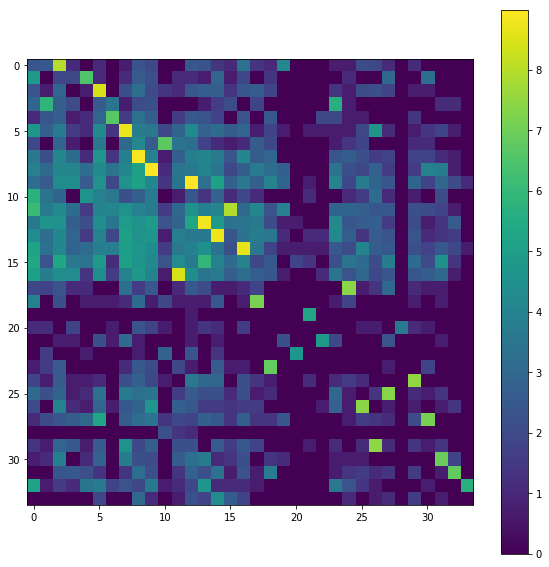

In [69]:
pu.plot_gr(pcr.to_graph(), log = 1)

In [70]:
gr = pcr.to_graph()

In [75]:
gr[0].astype(int)

array([  10,   11, 2968,    2,    0,    2,    0,    1,    9,    6,    0,
          0,   11,    9,    3,    2,   28,    3,    2,   62,    0,    0,
          0,    1,    1,    7,    6,    2,    0,    2,    0,    0,    0,
          0])

In [156]:
pcr.to_pairs()

{(1.0, 2.0): 22591,
 (2.0, 3.0): 33354,
 (2.0, 4.0): 34526,
 (4.0, 5.0): 28577,
 (5.0, 6.0): 17533,
 (2.0, 2.0): 38863,
 (3.0, 1.0): 16157,
 (2.0, 1.0): 6559,
 (3.0, 2.0): 24744,
 (2.0, 5.0): 8971,
 (5.0, 4.0): 4206,
 (5.0, 3.0): 9964,
 (4.0, 4.0): 5188,
 (6.0, 2.0): 7816,
 (3.0, 3.0): 5625,
 (3.0, 4.0): 6201,
 (5.0, 2.0): 14379,
 (3.0, 6.0): 2126,
 (6.0, 5.0): 3707,
 (6.0, 3.0): 5380,
 (6.0, 6.0): 1206,
 (3.0, 5.0): 5649,
 (4.0, 1.0): 3085,
 (4.0, 3.0): 4835,
 (4.0, 2.0): 15344,
 (6.0, 4.0): 5301,
 (2.0, 6.0): 3925,
 (5.0, 1.0): 2387,
 (5.0, 5.0): 4202,
 (6.0, 1.0): 1456,
 (1.0, 3.0): 2606,
 (1.0, 5.0): 1723,
 (1.0, 4.0): 2497,
 (4.0, 6.0): 1550,
 (1.0, 6.0): 599,
 (1.0, 1.0): 893}

In [118]:
bp = np.array([[-1.,  1.,  2.,  3., -1., -1.],
           [-1.,  2.,  4.,  5.,  6., -1.],
           [ 0.,  0.,  0.,  0.,  0., -1.],
           [ 0.,  0.,  0.,  0.,  1.,  2.],
           [ 0.,  0.,  0.,  0.,  2.,  4.],
           [ 0.,  0.,  0.,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [119]:
fp = np.array([[-1.,  1.,  2.,  3., -1., -1.],
           [-1.,  2.,  4.,  5.,  6., -1.],
           [ 4.,  5.,  6., -1.,  0.,  0.],
           [ 5.,  6.,  0.,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [120]:
pcr._debug_set_populations(fp, bp)

In [121]:
#pcr._copy([3,1], [3,4])
pcr._copy([3,1], [0,1])

[ 1.  2.  3. -1. -1.]


In [122]:
pcr.f_population

array([[-1.,  1.,  2.,  3., -1., -1.],
       [-1.,  2.,  4.,  5.,  6., -1.],
       [ 4.,  5.,  6., -1.,  0.,  0.],
       [ 5.,  6.,  1.,  2.,  3., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [123]:
pcr.b_population

array([[-1.,  1.,  2.,  3., -1., -1.],
       [-1.,  2.,  4.,  5.,  6., -1.],
       [ 0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  1.,  2.],
       [ 0.,  0.,  0.,  0.,  2.,  4.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [17]:
fm, bm, nf,nb = pcr._make_annealing_masks()
pcr._increase_populations(nf, nb)

In [18]:
fm

array([[2, 2, 2, 0, 2, 2],
       [2, 2, 2, 2, 1, 2],
       [2, 0, 1, 2, 2, 1],
       [0, 1, 2, 1, 2, 1]])

In [19]:
bm

array([[2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 1, 2],
       [2, 2, 2, 2, 1, 2],
       [2, 1, 1, 2, 1, 2],
       [0, 0, 2, 2, 1, 0]])

In [20]:
fi, bi = pcr._make_annealing_linkage(fm, bm)

(7, 6)


In [21]:
fi

array([[ 0,  3],
       [ 2,  1],
       [ 3,  0],
       [ 4, -1],
       [ 5, -1],
       [ 6, -1],
       [ 3,  1],
       [ 3,  5],
       [ 3,  3],
       [ 2,  2],
       [ 1,  4],
       [ 2,  5]])

In [22]:
bi

array([[5, 6],
       [6, 6],
       [7, 6],
       [4, 0],
       [4, 1],
       [4, 5],
       [3, 2],
       [3, 1],
       [1, 4],
       [4, 4],
       [2, 4],
       [3, 4]])

In [23]:
pcr.b_population

array([[-1.,  1.,  2.,  3., -1., -1.],
       [-1.,  2.,  4.,  5.,  6., -1.],
       [ 0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0., -1.,  1.,  2.],
       [ 0.,  0.,  0., -1.,  2.,  4.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [24]:
pcr.f_population

array([[-1.,  1.,  2.,  3., -1., -1.],
       [-1.,  2.,  4.,  5.,  6., -1.],
       [ 4.,  5.,  6., -1.,  0.,  0.],
       [ 5.,  6., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [25]:
for i in range(len(fi)):
    pcr._copy(fi[i], bi[i])

[ 0.  0.  0. -1.  2.  4.]
0 6
[ 0.  0. -1.  2.  4.]
0 5


ValueError: could not broadcast input array from shape (2) into shape (0)

In [16]:
pcr.b_population

array([[-1.,  1.,  2.,  3., -1., -1.],
       [-1.,  2.,  4.,  5.,  6., -1.],
       [ 0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0., -1.,  1.,  2.],
       [ 0.,  0.,  0., -1.,  2.,  4.]])

In [268]:
bi[0][1]

6